In [1]:
import math
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import bootstrap
from scipy import stats
pd.options.mode.chained_assignment = None 

In [2]:
def plot_lowess(x, y, **kwargs):
    '''Plots lowess line depending on fraction'''
    
    z = lowess(np.array(y),np.array(x),frac=0.3)
    y2 = z[:,1]
    plt.plot(x,y2, **kwargs)
    
def plot_ci(x, y1, y2, **kwargs):
    plt.fill_between(x, y1, y2, **kwargs)
    
def classify(n, bins):
    rbins = [0] + bins + [1]
    for i,b in enumerate(rbins):
        if i==0:
            if n<=b:
                return b
        else:
            if n>rbins[i-1] and n<=b:
                return b

Read data

In [3]:
d = pd.read_csv("../stats/merged.tab.gz",sep="\t", header=None)
d.columns = ["mq", "mqranksum", "baseqranksum", 
             "af", "ad", "dp", "miss", "n_snps", 
             "scaf", "start", "end", "nature", 
             "dist1", "dist2", "lift", "rel_pos"]
svars = [v for v in d.columns[:8] if v!="baseqranksum"]
d["species"] = [n.split(".")[0] for n in d.nature]
d["region"] = [n.split(".")[1] for n in d.nature]
d["rel_pos"] = [np.round(r, decimals=2) for r in d.rel_pos]
bins = sorted(d[d.region=="hotspots"].rel_pos.unique())
d["rel_pos"] = [classify(r, bins) for r in d.rel_pos]
d["spot_id"] = d.scaf + ":" + list(map(str,d.start)) + "-" + list(map(str,d.end))

Remove rows with NaNs in variables

In [4]:
d = d[[all(not math.isnan(v) for v in l) for l in d[svars].values]].reset_index(drop=True)

Close or far to feature (cpgi or hotspot)

In [7]:
th = 1e3
d["close_bool"] = ["close" if distance<=th else "far" if distance>=10e3 else "intermediate" for distance in d.dist2]

Get 95% CI around mean

In [8]:
subd = d[(d.close_bool!="intermediate") 
         & (d.rel_pos.between(0.05,0.95)) 
         & (d.dp<400)]

In [9]:
results_l = []
group_vars = ["species","region","rel_pos", "close_bool"]

for comb, df in subd.groupby(group_vars):
    for v in svars:
        if len(df[v])>=10:
            boot = bootstrap((df[v].values,), statistic=np.mean ,n_resamples=100)
            ci = list(boot.confidence_interval)
            mean = df[v].mean()
            results_l.append(list(comb) + [mean] + ci + [v])

mci = pd.DataFrame(results_l)
mci.columns = group_vars + ["mean", "low", "high", "variable"]
mci["hue_var"] = mci.species + "." + mci.close_bool

Plotting

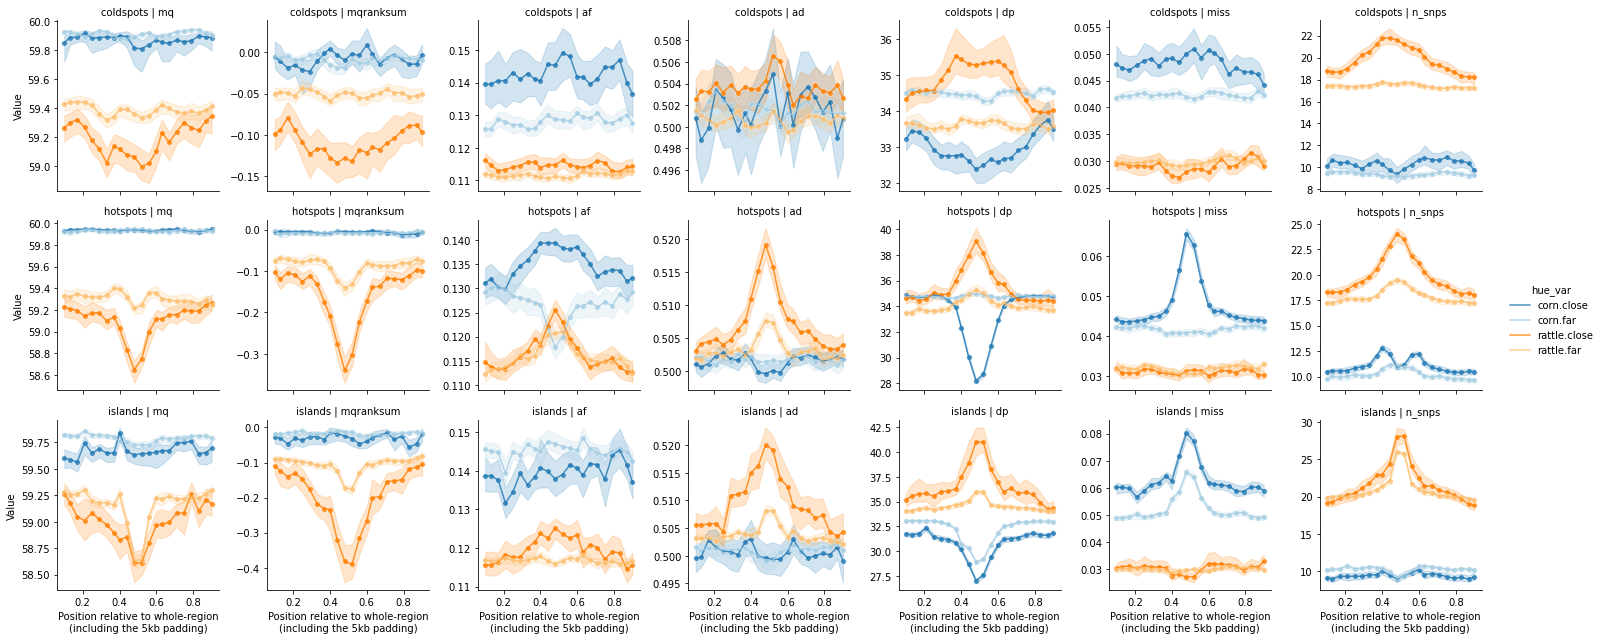

In [10]:
palette = {"rattle.close":sns.color_palette("Paired")[7], "rattle.far":sns.color_palette("Paired")[6], 
           "corn.close":sns.color_palette("Paired")[1], "corn.far":sns.color_palette("Paired")[0]}

g = sns.FacetGrid(data=mci[mci.rel_pos.between(0.1,0.9)], 
                  row="region", col="variable", 
                  hue="hue_var", palette=palette,
                  sharey=False)
g.map(plot_ci, "rel_pos", "low", "high", alpha=0.2)
g.map(sns.scatterplot, "rel_pos", "mean", s=30, alpha=0.8)
g.map(sns.lineplot, "rel_pos", "mean", alpha=0.8)
g.add_legend()
g.set_titles(row_template = '{row_name}', 
             col_template = '{col_name}')
g.set_axis_labels("Position relative to whole-region\n(including the 5kb padding)", 
                  "Value")
g.tight_layout()
g.savefig("pdfs/vcf_stats_hotspots10x.jpg", dpi=400)

Stats from bam

In [3]:
b = pd.read_csv("../stats_bam/merged.tab.gz",sep="\t",header=None)
b.columns = ["n_reads", "bp_covered", "frac_covered", "dp", "baseQ","MQ", 
             "scaf", "start", "end", "nature", "dist1", "dist2", "lift_bp", "dist2sp", "heat",
             "rel_pos", "indv"]
svars = ["frac_covered", "MQ","dp", "baseQ"]
b["rel_pos"] = [np.round(r, decimals=2) for r in b.rel_pos]
b["species"] = [n.split(".")[0] for n in b.nature]
b["region"] = [n.split(".")[1] for n in b.nature]
bins = sorted(b[b.region=="hotspots"].rel_pos.unique())
b["rel_pos"] = [classify(r, bins) for r in b.rel_pos]
b["spot_id"] = ["{}:{}-{}".format(r.scaf, r.start+5000, r.end-5000) for i,r in b.iterrows()]

FileNotFoundError: [Errno 2] No such file or directory: '../stats_bam/merged.tab.gz'

Close or far to feature (cpgi or hotspot)

In [12]:
th = 1e3
b["close_bool"] = ["close" if distance<=th else "far" if distance>=10e3 else "intermediate" for distance in b.dist2]

Get 95% CI for mean across groups

In [14]:
subd = b[(b.close_bool!="intermediate")
         & (b.rel_pos.between(0.05,0.95))
         & (b.dp < 300) 
         & (b.indv.isin(["EG431-284-2015-2", "Viridis_SRR10593904"]))]

In [16]:
results_l = []
group_vars = ["species","region","rel_pos", "close_bool"]

for comb, df in subd.groupby(group_vars):
    for v in svars:
        if len(df[v])>=10:
            boot = bootstrap((df[v].values,), statistic=np.mean ,n_resamples=5)
            ci = list(boot.confidence_interval)
            mean = df[v].mean()
            results_l.append(list(comb) + [mean] + ci + [v])

mbci = pd.DataFrame(results_l)
mbci.columns = group_vars + ["mean", "low", "high", "variable"]
mbci["hue_var"] = mbci.species + "." + mbci.close_bool

#pd.DataFrame(b.groupby("indv").dp.mean()).sort_values(by="dp").tail(30)

/Users/marc/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_resampling.py:124: RuntimeWarning: invalid value encountered in double_scalars
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_resampling.py:126: RuntimeWarning: invalid value encountered in double_scalars
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_resampling.py:92: DegenerateDataWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(DegenerateDataWarning(msg))


Plotting

In [25]:
b[b.region=="islands"].nature.unique()

array(['corn.islands', 'rattle.islands'], dtype=object)

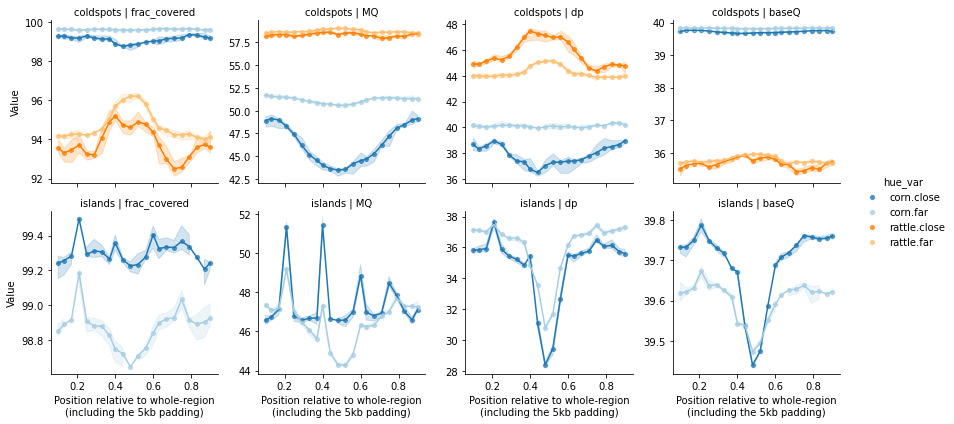

In [17]:
palette = {"rattle.close":sns.color_palette("Paired")[7], "rattle.far":sns.color_palette("Paired")[6], 
           "corn.close":sns.color_palette("Paired")[1], "corn.far":sns.color_palette("Paired")[0]}

g = sns.FacetGrid(data=mbci[mbci.rel_pos.between(0.1,0.9)], 
                  row="region", col="variable", 
                  hue="hue_var", palette=palette,
                  sharey=False)
g.map(plot_ci, "rel_pos", "low", "high", alpha=0.2)
g.map(sns.scatterplot, "rel_pos", "mean", s=30, alpha=0.8)
g.map(sns.lineplot, "rel_pos", "mean")
g.add_legend()
g.set_titles(row_template = '{row_name}', 
             col_template = '{col_name}')
g.set_axis_labels("Position relative to whole-region\n(including the 5kb padding)", "Value")
g.tight_layout()

Relationship between heat and statistics

In [26]:
def center2flank_stats(df, svars):
    center = df[df.rel_pos.between(0.4,0.6)]
    flanks = df[~df.rel_pos.between(0.4,0.6)]
    c_stats = center[svars].mean()
    f_stats = flanks[svars].mean()
    rel_stats = c_stats/f_stats
    heat = pd.Series([df.heat.values[0]], index=["heat"])
    sp = pd.Series([df.species.values[0]], index=["species"])
    rel_stats = rel_stats.append(heat)
    rel_stats = rel_stats.append(sp)
    return rel_stats

In [27]:
hotspots = b[b.region=="hotspots"]
cf = hotspots.groupby(["spot_id", "close_bool"]).apply(lambda x: center2flank_stats(df=x, svars=svars)).reset_index()

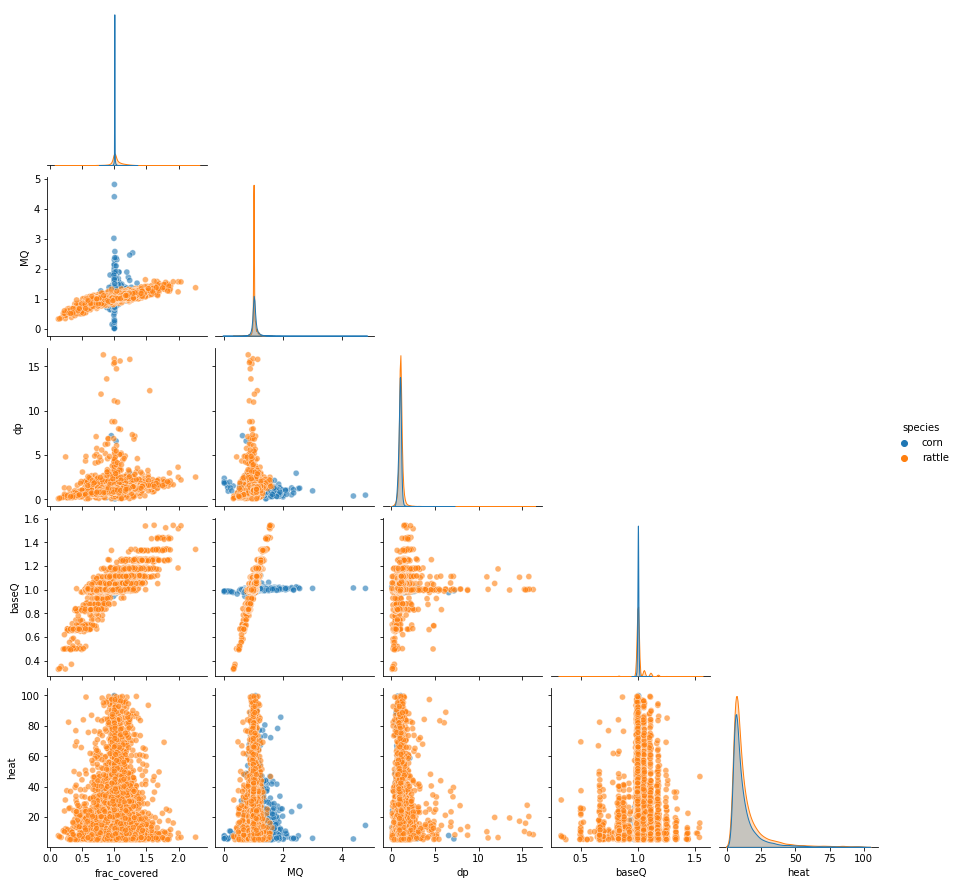

In [28]:
sns.pairplot(data=cf[cf.heat<100], vars=cf.columns[2:-1], 
             hue="species", 
             corner=True,
             plot_kws={"alpha":0.6})

In [29]:
subd = cf[(cf.species=="rattle") & 
          (cf.heat<50)]
subd["dp_bin"] = pd.qcut(subd.dp, 20)
bins = subd.groupby("dp_bin")["heat"].mean().reset_index()
#sns.stripplot(data=bins, x="dp_bin", y="heat")

In [30]:
for sp,df in cf.groupby(["species", "close_bool"]):
    df = df.dropna()
    spear = stats.spearmanr(df.heat, df.dp)
    #spear = stats.pearsonr(df.heat, df.dp)
    print(sp, spear)

('corn', 'close') SpearmanrResult(correlation=-0.07887732199318592, pvalue=1.4389374120736438e-07)
('corn', 'far') SpearmanrResult(correlation=0.006137845659299091, pvalue=0.6051895658938745)
('corn', 'intermediate') SpearmanrResult(correlation=-0.012243204920566667, pvalue=0.5893600033723503)
('rattle', 'close') SpearmanrResult(correlation=0.09412040329476568, pvalue=2.1353659884675126e-09)
('rattle', 'far') SpearmanrResult(correlation=0.021158120011204675, pvalue=0.03414777390476958)
('rattle', 'intermediate') SpearmanrResult(correlation=0.019707130278699417, pvalue=0.2073110706309056)
